In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from prettytable import PrettyTable
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Evaluation of trained model without retraining

In [13]:
batch_size = 8
num_classes= 2
img_path = '/kaggle/input/ear-real-spoof-database'

In [14]:
# Initially load data and apply transformation to them
all_transforms = transforms.Compose([
    # Color randomizers
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=3),
    # Randomized whole image manipulation
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    # Resize, to tensor and normalize the image.
    transforms.Resize((132,132)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])
dataset = datasets.ImageFolder(img_path, transform=all_transforms)
print(dataset.class_to_idx)

# generator=torch.Generator().manual_seed(42)
# for reproduceable results, add this to random_split

# now split the dataset to get the test dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Print sizes
print(f' Test: {test_size}')

# Put dataset in dataloader
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

{'Real': 0, 'Spoof': 1}
 Test: 832


In [15]:
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.show()

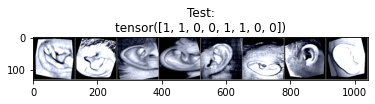

In [16]:
images, labels = iter(test_loader).next()
imshow(torchvision.utils.make_grid(images), f"Test:\n{labels}" )

## Load model

In [18]:
# Creating a CNN class
class SpoofDetectionNetwork(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, l1=64, l2=16):
        # Also found with __init__(self, input_dimension, output_dimension)
        super(SpoofDetectionNetwork, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm1 = nn.BatchNorm2d(32)
        
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm2 = nn.BatchNorm2d(64)
        
        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        
        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm4 = nn.BatchNorm2d(96)
        
        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm5 = nn.BatchNorm2d(32)
        
        # After convolution layers
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, l1)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l1, l2)
        self.fc_relu2 = nn.ReLU()
        self.fc3 = nn.Linear(l2, 1)
        self.fc_sigmoid = nn.Sigmoid()
    
    # Progresses data across layers    
    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        out = self.batchNorm1(out)
        
        # Layer 2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        out = self.batchNorm2(out)
        
        # Layer 3
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        out = self.batchNorm3(out)
        
        # Layer 4
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        out = self.batchNorm4(out)
        
        # Layer 5
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        out = self.batchNorm5(out)
        
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc_relu1(self.fc1(out))
        out = self.fc_relu2(self.fc2(out))
        out = self.fc_sigmoid(self.fc3(out))

        return out

In [19]:
model = SpoofDetectionNetwork()
model.load_state_dict(torch.load("/kaggle/input/personal-best-model-for-ear-spoof/best_model_32_16_8_0.001_4_0.005_0.498.h5"))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Computing on {device}')

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

Computing on cuda


## Testing

Predicted labels 


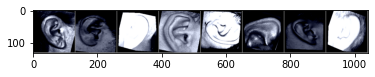

In [20]:
# Test image batch with predicted outputs and the pictures
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images.to(device))
with torch.no_grad():
    predicted = torch.flatten(torch.round(outputs)).float()
    # show images
    print("Predicted labels ")
    imshow(torchvision.utils.make_grid(images.cpu()), 'f"Pred: {predicted.cpu()}\nAct:   {labels.float()}"' )

In [21]:
# Testing
with torch.no_grad():
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    
    pred_labels = np.array([])
    act_labels = np.array([])

    for images, labels in test_loader: # number of elements defined by batch size
        images = images.to(device)
        labels = labels.to(device).int()
        outputs = model(images)
        predicted = torch.flatten(torch.round(outputs)).int()
        
        pred_labels = np.append(pred_labels, predicted.cpu())
        act_labels = np.append(act_labels, labels.cpu())
        
        for i in range(labels.size(dim=-1)):
            label = labels[i]
            n_class_samples[label] += 1
            if (label == predicted[i]):
                n_class_correct[label] += 1

+---------+----------+
|  Class  | Accuracy |
+---------+----------+
| Overall |  99.76%  |
|   Real  |  99.78%  |
|  Spoof  |  99.74%  |
+---------+----------+
+-----------+------------------------+-----------------+-------+-------+----------+
| Precision | Sensitivity/TPR/Recall | Specificity/TNR |  FPR  |  FNR  | F1-Score |
+-----------+------------------------+-----------------+-------+-------+----------+
|   99.78%  |         99.78%         |      99.74%     | 0.26% | 0.22% |  99.78%  |
+-----------+------------------------+-----------------+-------+-------+----------+


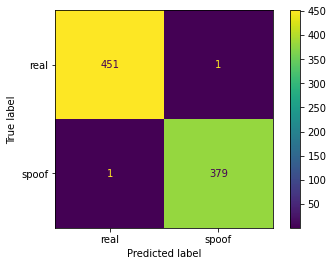

In [22]:
# Accuracy values
t = PrettyTable(['Class', 'Accuracy'])
acc = 100.0 * np.array(n_class_correct).sum() / np.array(n_class_samples).sum()
t.add_row(['Overall', f"{acc:.2f}%"])

for i in range(num_classes):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    t.add_row([dataset.classes[i], f"{acc:.2f}%"])

print(t)

conf_mtx = confusion_matrix(act_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=['real', 'spoof'])
disp.plot();

TP, FN, FP, TN = conf_mtx.ravel()

rec = ((TP) / (TP+FN)) * 100
spec = ((TN) / (TN+FP)) * 100
prec = ((TP) / (TP+FP)) * 100
fpr = ((FP) / (FP+TN)) * 100
fnr = ((FN) / (TP+FN)) * 100
f1s = ((2 * prec * rec) / (prec + rec))

t = PrettyTable(['Precision', 'Sensitivity/TPR/Recall', 'Specificity/TNR',  'FPR', 'FNR', 'F1-Score'])
t.add_row([f"{prec:.2f}%", f"{rec:.2f}%", f"{spec:.2f}%", f"{fpr:.2f}%", f"{fnr:.2f}%", f"{f1s:.2f}%"])
print(t)
